## Imports

In [ ]:
import os
from pathlib import Path
import json

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend

import matplotlib.pyplot as plt
from matplotlib import colors

import random

import numpy as np
from numpy import genfromtxt

#for the decision tree
from xgboost import XGBClassifier
import pdb


from scipy.stats import ttest_rel

import pandas as pd

#CNN
!pip install np_utils
from keras.utils.np_utils import to_categorical

import gc
import cv2
import time

import seaborn as sns

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader


     |████████████████████████████████| 61 kB 4.6 MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57132 sha256=e2cccafef32238d0149634fde3311473a9b0d7f7ed6e6738c5cab6f1baf05d5c
  Stored in directory: /root/.cache/pip/wheels/8c/4e/ef/095c24693723c329f4cdc1079861cdbb2487d4b41b2496a4e7
Successfully built np-utils


## Data paths

In [ ]:
#Upload MAML-data.zip

from google.colab import files
files.upload()

Saving MAML-data.zip to MAML-data.zip


{'MAML-data.zip': b'PK\x03\x04\x14\x00\x00\x00\x00\x00=\xb5\x0bS\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1a\x00\x00\x00data-20210811T135357Z-001/PK\x03\x04\x14\x00\x00\x00\x08\x00:\xb5\x0bS_\xd8\xf1=\x06M\x07\x00\xcf\x98\x07\x00"\x00\x00\x00data-20210811T135357Z-001/data.zip\x9c\x9aSp6\xdc\x15\x85c\xdb\xb6m;yc\xbf\xb1m\xfb\x8f\xda/\xb6m\xdb\xb6m\xdb\xc9\x1f\xdbN\xdb\xe9t\xda\xe9\xb4\x9d\xb6{\xe6\\\x9dg\xaf\x9b\xb3.\xce\xec\xb5\x95\xe5\xc0!0@\xfeR7M\xf0@\x90\x7f(\xc8?\x1f3c7c\xe6\xbf#\xf2\xff\x84\xa0\xfc\r1\xf70\xb6s7v\xb3vt\xf8\x0f4\xce\xbf\xa0]\xcc]\xdd\xed\xdc\\\xffC\x17\xe5\x7f\xe8\xb27vp7\xb63t3v\xb5\xfd\xbb\x04\x0c\x88&\xdb\x99j\x89n\xfc\x87\x17(\x08\x08-\x18\x08\x08\xef\x7f+a\xefhfnghlj\xea\xeebljm\xee\xca\xe4\xe0\xf4[q\x8c\x924\x98(\xc6\x88gco\xe6\xd7\x0b\xc1\x8e\x07\xe4\x1d\xc1/\x04c\x8e\xb8\xf6\x14\x0c\xbb\xbc\xb1\x8e\x18\x8a\xd3\x1aG\x0fD\xf9`&\x93\x1c\x81\xa5\xe2\x9am~HL\xb7s"\x89T\x12>3\t\x08@6\xdfj[\xc7J\xf7\rK\xd7K\xb7\xa3\xff\xcd\xd5$~\xfc\xb2B\xce\xe6\xf1\x84IF

In [ ]:
!unzip data.zip

Archive:  MAML-data.zip
   creating: data-20210811T135357Z-001/
  inflating: data-20210811T135357Z-001/data.zip  
  inflating: data-20210811T135357Z-001/Learning_robots_Evaluation_for_submission.ipynb  
  inflating: data/evaluation/results/manual_tasks/model_accuracies.npy  
  inflating: data/evaluation/results/manual_tasks/pics/result_0_cnn.png  
  inflating: data/evaluation/results/manual_tasks/pics/result_0_decision_tree.png  
  inflating: data/evaluation/results/manual_tasks/pics/result_0_maml.png  
  inflating: data/evaluation/results/manual_tasks/pics/result_1_cnn.png  
  inflating: data/evaluation/results/manual_tasks/pics/result_1_decision_tree.png  
  inflating: data/evaluation/results/manual_tasks/pics/result_1_maml.png  
  inflating: data/evaluation/results/manual_tasks/pics/result_2_cnn.png  
  inflating: data/evaluation/results/manual_tasks/pics/result_2_decision_tree.png  
  inflating: data/evaluation/results/manual_tasks/pics/result_2_maml.png  
  inflating: data/evaluat

In [ ]:
#TODO: create directories if they don't exist
data_path = Path('/content/data')
training_path = data_path / 'training'
test_path = data_path / 'test'
eval_task_path = Path('/content/data/evaluation/tasks/')
eval_results_path = Path('/content/data/evaluation/results/')


#MAML

## Regression Model

In [ ]:
#Source: Learning Robots Moodle page
class RegressionModel(keras.Model):
    """
    Creates a feed forward neural network for regression. Architecture is as described in the original
    MAML paper.
    """
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Conv2D(50,kernel_size=(3,3), padding='same',input_shape=(None,10,10,1), dtype="float32")
        self.hidden2 = keras.layers.Conv2D(100,kernel_size=(3,3),padding='same', dtype="float32")
        self.out = keras.layers.Dense(10, dtype="float32")

    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

## Training script

In [ ]:
def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    plt.tight_layout()
    plt.imshow(task,cmap=cmap, norm=norm)
    plt.show()

def loss_function(y, y_pred):
	"""
	Mean Squared Error Loss Function
	:param pred_y: predicted y value
	:param y: true y value
	:return: MSE between y_pred and y
	"""

	return keras_backend.mean(keras.losses.mean_squared_error(y, y_pred))


def np_to_tensor(list_of_numpy_objs):
	return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)


def compute_loss(model, x, y, loss_fn=loss_function):
	"""
	Computes the total loss of the model and one forward pass
	:param model:
	:param x: inputs
	:param y: outputs
	:param loss_fn: loss function to use
	:return: tuple of total loss and model output
	"""
	y_pred = model.forward(x)
	mse = loss_fn(y, y_pred)
	return mse, y_pred


def compute_gradients(model, x, y, loss_fn=loss_function):
	"""
	Compute the gradients for a given model wrt to a given loss function
	:param model: model to compute grads for
	:param x: input
	:param y: output
	:param loss_fn: loss function
	:return: tuple of gradient tape and loss
	"""
	with tf.GradientTape() as tape:
		loss, _ = compute_loss(model, x, y, loss_fn)
	return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
	"""
	Applies the gradient to network parameters
	:param optimizer: optimizer to use, e.g. adam
	:param gradients: gradient tape
	:param variables: variables to update
	:return: none
	"""
	optimizer.apply_gradients(zip(gradients, variables))


def train_batch(x, y, model, optimizer):
	"""
	Train model on a batch of data
	:param x: input data
	:param y: outputs
	:param model: model to use
	:param optimizer: opimizer to use
	:return: loss of the training step
	"""
	tensor_x, tensor_y = np_to_tensor((x, y))
	gradients, loss = compute_gradients(model, tensor_x, tensor_y)
	apply_gradients(optimizer, gradients, model.trainable_variables)
	return loss


def train(model, epochs, dataset, lr_inner=0.01, batch_size=1, log_steps=1000):
	"""
	Train a model using the MAML algorithm
	:param model: model to train
	:param epochs: number of epochs (i.e. passed through the whole dataset)
	:param dataset: dataset to train on
	:param lr_inner: learning rate of inner updates
	:param batch_size: batch size for updates
	:param log_steps: logging interval
	:return:
	"""
	optimizer = keras.optimizers.Adam()

	# Step 2: instead of checking for convergence, we train for a number
	# of epochs
	print("Traning MAML for %d Epochs" % epochs)
	for ei in range(epochs):
		print("Training Progress: %d/%d" % (ei, epochs))
		total_loss = 0
		losses = []
		# Step 3 and 4
		for i, t in enumerate(random.sample(dataset, len(dataset))):
			x,y = tf.convert_to_tensor(t, dtype='float32')
			x=np.expand_dims(x,axis=0)
			x=np.expand_dims(x,axis=0)
			y=np.reshape(y,(1,1,10,10))


			model.forward(x)  # run forward pass to initialize weights

			with tf.GradientTape() as test_tape:
				# Step 5
				with tf.GradientTape(persistent=True) as train_tape: #changed Persistent to True
					train_loss, y_pr = compute_loss(model, x, y)

				# Step 6
				gradients = train_tape.gradient(train_loss, model.trainable_variables)
				k = 0
				model_copy = copy_model(model, x)
				for j in range(len(model_copy.layers)):
					model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
															  tf.multiply(lr_inner, gradients[k]))
					model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
															tf.multiply(lr_inner, gradients[k + 1]))
					k += 2
				# Step 8
				test_loss, logits = compute_loss(model_copy, x, y)
			# Step 8
			gradients = test_tape.gradient(test_loss, model.trainable_variables)
			optimizer.apply_gradients(zip(gradients, model.trainable_variables))

			# Logs
			total_loss += test_loss
			loss = total_loss / (i + 1.0)
			
			losses.append(loss)


			if i % log_steps == 0 and i > 0:
				print('Step {}: loss = {}'.format(i, loss))
	return model


def copy_model(model, x):
	"""
	Creates a copy of a model
	:param model: model to copy
	:param x: input
	:return: copy of the model
	"""
	copied_model = RegressionModel()
 
	# One forward pass is required to initialize parameters
	copied_model.forward(tf.convert_to_tensor(x))
	copied_model.set_weights(model.get_weights())
	return copied_model

## Helper functions

In [ ]:
def copy_model(model, x):
    # Copy model weights to a new model.

    copied_model = RegressionModel()

    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))

    copied_model.set_weights(model.get_weights())
    return copied_model


def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    plt.tight_layout()
    plt.imshow(task,cmap=cmap, norm=norm)
    plt.show()

##Prepare the data

In [ ]:
img_size = (10,10)
dim_input = np.prod(img_size)

#load the data
with open(os.path.join(training_path,'00d62c1b.json')) as json_file:
   data = json.load(json_file)

prep_input, prep_output = [], []

for d in data['train']:
   if len(d['input']) == 10:
       prep_input.append(([d['input']][0],[d['output']][0]))

prep_input=np.array(prep_input)


## Training the model

Traning MAML for 50 Epochs
Training Progress: 0/50
Training Progress: 1/50
Training Progress: 2/50
Training Progress: 3/50
Training Progress: 4/50
Training Progress: 5/50
Training Progress: 6/50
Training Progress: 7/50
Training Progress: 8/50
Training Progress: 9/50
Training Progress: 10/50
Training Progress: 11/50
Training Progress: 12/50
Training Progress: 13/50
Training Progress: 14/50
Training Progress: 15/50
Training Progress: 16/50
Training Progress: 17/50
Training Progress: 18/50
Training Progress: 19/50
Training Progress: 20/50
Training Progress: 21/50
Training Progress: 22/50
Training Progress: 23/50
Training Progress: 24/50
Training Progress: 25/50
Training Progress: 26/50
Training Progress: 27/50
Training Progress: 28/50
Training Progress: 29/50
Training Progress: 30/50
Training Progress: 31/50
Training Progress: 32/50
Training Progress: 33/50
Training Progress: 34/50
Training Progress: 35/50
Training Progress: 36/50
Training Progress: 37/50
Training Progress: 38/50
Training

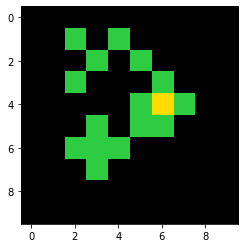

In [ ]:
# Reproduction
np.random.seed(1234)

model = RegressionModel()

train(model,50,list(prep_input))
x_test=tf.convert_to_tensor(prep_input[0][0], dtype='float32')
x_test=np.expand_dims(x_test,axis=0)
x_test=np.expand_dims(x_test,axis=0)
y_pred=model.forward(x_test)
y_pred=np.reshape(y_pred,(10,10))
plot_task(y_pred)

#Decision tree

code by: Siddhartha (Kaggle: meaninglesslives)

##Plotting functions

In [ ]:
def plot_result(test_input, test_prediction,
                input_shape):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 2, figsize=(15,15))
    test_input = test_input.reshape(input_shape[0],input_shape[1])
    axs[0].imshow(test_input, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Actual Target')
    test_prediction = test_prediction.reshape(input_shape[0],input_shape[1])
    axs[1].imshow(test_prediction, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Model Prediction')
    plt.tight_layout()
    plt.show()
    
def plot_test(test_prediction, task_name):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(test_prediction, cmap=cmap, norm=norm)
    axs.axis('off')
    axs.set_title(f'Test Prediction {task_name}')
    plt.tight_layout()
    plt.show()

##Get features

In [ ]:
#General structure features

#Moore neighbours
def get_moore_neighbours(color, cur_row, cur_col, nrows, ncols):

    if cur_row<=0: top = -1
    else: top = color[cur_row-1][cur_col]
        
    if cur_row>=nrows-1: bottom = -1
    else: bottom = color[cur_row+1][cur_col]
        
    if cur_col<=0: left = -1
    else: left = color[cur_row][cur_col-1]
        
    if cur_col>=ncols-1: right = -1
    else: right = color[cur_row][cur_col+1]
        
    return top, bottom, left, right

#Colours in row/column
def get_tl_tr(color, cur_row, cur_col, nrows, ncols):
        
    if cur_row==0:
        top_left = -1
        top_right = -1
    else:
        if cur_col==0: top_left=-1
        else: top_left = color[cur_row-1][cur_col-1]
        if cur_col==ncols-1: top_right=-1
        else: top_right = color[cur_row-1][cur_col+1]   
        
    return top_left, top_right

In [ ]:
#Make all features
def make_features(input_color, nfeat):
    nrows, ncols = input_color.shape
    feat = np.zeros((nrows*ncols,nfeat))
    cur_idx = 0
    for i in range(nrows):
        for j in range(ncols):
            feat[cur_idx,0] = i
            feat[cur_idx,1] = j
            feat[cur_idx,2] = input_color[i][j]
            feat[cur_idx,3:7] = get_moore_neighbours(input_color, i, j, nrows, ncols)
            feat[cur_idx,7:9] = get_tl_tr(input_color, i, j, nrows, ncols)
            feat[cur_idx,9] = len(np.unique(input_color[i,:]))
            feat[cur_idx,10] = len(np.unique(input_color[:,j]))
            feat[cur_idx,11] = (i+j)
            feat[cur_idx,12] = len(np.unique(input_color[i-local_neighb:i+local_neighb,
                                                         j-local_neighb:j+local_neighb]))

            cur_idx += 1
        
    return feat

In [ ]:
#for training
def features(task, mode='train'):
    num_train_pairs = len(task[mode])
    feat, target = [], []
    
    global local_neighb
    for task_num in range(num_train_pairs):
        input_color = np.array(task[mode][task_num]['input'])
        target_color = task[mode][task_num]['output']
        nrows, ncols = len(task[mode][task_num]['input']), len(task[mode][task_num]['input'][0])

        target_rows, target_cols = len(task[mode][task_num]['output']), len(task[mode][task_num]['output'][0])
        
        if (target_rows!=nrows) or (target_cols!=ncols):
            print('Number of input rows:',nrows,'cols:',ncols)
            print('Number of target rows:',target_rows,'cols:',target_cols)
            not_valid=1
            return None, None, 1

        imsize = nrows*ncols
        offset = imsize*task_num*3 #since we are using three types of aug
        feat.extend(make_features(input_color, nfeat))
        target.extend(np.array(target_color).reshape(-1,))
            
    return np.array(feat), np.array(target), 0

##Training

In [ ]:
mode = 'train'
if mode=='eval':
    task_path = evaluation_path
elif mode=='train':
    task_path = training_path
elif mode=='test':
    task_path = test_path

all_task_ids = sorted(os.listdir(task_path))

nfeat = 13
local_neighb = 8
valid_scores = {}

model_accuracies = {'ens': []}
pred_taskids = []

for task_id in all_task_ids:

    task_file = str(task_path / task_id)
    with open(task_file, 'r') as f:
        task = json.load(f)

    feat, target, not_valid = features(task)
    if not_valid:
        print('ignoring task', task_file)
        print()
        not_valid = 0
        continue

    xgb =  XGBClassifier(n_estimators=25, n_jobs=-1)
    xgb.fit(feat, target, verbose=-1)




In [ ]:
if (mode=='train') or (mode=='eval'):
    df = pd.DataFrame(model_accuracies, index=pred_taskids)
    print(df.head(10))

    print(df.describe())
    for c in df.columns:
        print(f'for {c} no. of complete tasks is', (df.loc[:, c]==1).sum())

Empty DataFrame
Columns: [ens]
Index: []
       ens
count  0.0
mean   NaN
std    NaN
min    NaN
25%    NaN
50%    NaN
75%    NaN
max    NaN
for ens no. of complete tasks is 0


# CNN

Code by Tarun Paparaju (Kaggle: tarunpaparaju)

##Settings

In [ ]:
T = torch.Tensor

SIZE = 1000
EPOCHS = 50
CONV_OUT_1 = 50
CONV_OUT_2 = 100
BATCH_SIZE = 128

##Training data

In [ ]:
test_task_files = sorted(os.listdir(test_path))

test_tasks = []
for task_file in test_task_files:
    with open(str(test_path / task_file), 'r') as f:
        task = json.load(f)
        test_tasks.append(task)

test_task_files = sorted(os.listdir(test_path))

test_tasks = []
for task_file in test_task_files:
    with open(str(test_path / task_file), 'r') as f:
        task = json.load(f)
        test_tasks.append(task)

In [ ]:
Xs_test, Xs_train, ys_train = [], [], []

for task in test_tasks:
    X_test, X_train, y_train = [], [], []
    

    for pair in task["test"]:
          X_test.append(pair["input"])

    for pair in task["train"]:
          if len(pair['input']) == 10:
            X_train.append(pair["input"])
            y_train.append(pair["output"])

    Xs_test.append(X_test)
    Xs_train.append(X_train)
    ys_train.append(y_train)



In [ ]:
matrices = []
for X_test in Xs_test:
    for X in X_test:
        matrices.append(X)

values = []
for matrix in matrices:
    for row in matrix:
        for value in row:
            values.append(value)

df = pd.DataFrame(values)
df.columns = ["values"]

In [ ]:
class ARCDataset(Dataset):
    def __init__(self, X, y, stage="train"):
        self.X = get_new_matrix(X)
        self.X = repeat_matrix(self.X)

        self.stage = stage
        if self.stage == "train":
            self.y = get_new_matrix(y)
            self.y = repeat_matrix(self.y)

    def __len__(self):
        return SIZE

    def __getitem__(self, idx):
        inp = self.X[idx]
        if self.stage == "train":
            outp = self.y[idx]

        if idx != 0:
            rep = np.arange(10)
            orig = np.arange(10)
            np.random.shuffle(rep)
            dictionary = dict(zip(orig, rep))
            inp = replace_values(inp, dictionary)
            if self.stage == "train":
                outp, outp_probs_len, outp_matrix_dims = get_outp(outp, dictionary)

        if idx == 0:
            if self.stage == "train":
                outp, outp_probs_len, outp_matrix_dims = get_outp(outp, None, False)

        return inp, outp, outp_probs_len, outp_matrix_dims, self.y

In [ ]:
def replace_values(a, d):
    return np.array([d.get(i, -1) for i in range(a.min(), a.max() + 1)])[a - a.min()]

def repeat_matrix(a):
    return np.concatenate([a]*((SIZE // len(a)) + 1))[:SIZE]

def get_new_matrix(X):
    if len(set([np.array(x).shape for x in X])) > 1:
        X = np.array([X[0]])
    return X

def get_outp(outp, dictionary=None, replace=True):
    if replace:
        outp = replace_values(outp, dictionary)

    outp_matrix_dims = outp.shape
    outp_probs_len = outp.shape[0]*outp.shape[1]*10
    outp = to_categorical(outp.flatten(),
                          num_classes=10).flatten()

    return outp, outp_probs_len, outp_matrix_dims

##Create the CNN

In [ ]:
class BasicCNNModel(nn.Module):
    def __init__(self, inp_dim=(10, 10), outp_dim=(10, 10)):
        super(BasicCNNModel, self).__init__()

        CONV_IN = 3
        KERNEL_SIZE = 3
        DENSE_IN = CONV_OUT_2
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dense_1 = nn.Linear(DENSE_IN, outp_dim[0] * outp_dim[1] * 10)

        if inp_dim[0] < 5 or inp_dim[1] < 5:
            KERNEL_SIZE = 1

        self.conv2d_1 = nn.Conv2d(CONV_IN, CONV_OUT_1, kernel_size=KERNEL_SIZE)
        self.conv2d_2 = nn.Conv2d(CONV_OUT_1, CONV_OUT_2, kernel_size=KERNEL_SIZE)

    def forward(self, x, outp_dim):
        x = torch.cat([x.unsqueeze(0)] * 3)
        x = x.permute((1, 0, 2, 3)).float()
        self.conv2d_1.in_features = x.shape[1]
        conv_1_out = self.relu(self.conv2d_1(x))
        self.conv2d_2.in_features = conv_1_out.shape[1]
        conv_2_out = self.relu(self.conv2d_2(conv_1_out))

        self.dense_1.out_features = outp_dim
        feature_vector, _ = torch.max(conv_2_out, 2)
        feature_vector, _ = torch.max(feature_vector, 2)
        logit_outputs = self.dense_1(feature_vector)

        out = []
        for idx in range(logit_outputs.shape[1] // 10):
            out.append(self.softmax(logit_outputs[:, idx * 10: (idx + 1) * 10]))
        return torch.cat(out, axis=1)


def transform_dim(inp_dim, outp_dim, test_dim):
    return (test_dim[0]*outp_dim[0]/inp_dim[0],
            test_dim[1]*outp_dim[1]/inp_dim[1])

def resize(x, test_dim, inp_dim):
    if inp_dim == test_dim:
        return x
    else:
        return cv2.resize(flt(x), inp_dim,
                          interpolation=cv2.INTER_AREA)

def flt(x): return np.float32(x)
def npy(x): return x.cpu().detach().numpy()
def itg(x): return np.int32(np.round(x))

##Training

In [ ]:
idx = 0
start = time.time()
test_predictions = []

for X_train, y_train in zip(Xs_train, ys_train):
    print("TASK " + str(idx + 1))

    train_set = ARCDataset(X_train, y_train, stage="train")
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    inp_dim = np.array(X_train[0]).shape
    outp_dim = np.array(y_train[0]).shape
    network = BasicCNNModel(inp_dim, outp_dim).cuda()
    optimizer = Adam(network.parameters(), lr=0.01)

    for epoch in range(EPOCHS):
        for train_batch in train_loader:
            train_X, train_y, out_d, d, out = train_batch
            train_preds = network.forward(train_X.cuda(), out_d.cuda())
            train_loss = nn.MSELoss()(train_preds, train_y.cuda())

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

    end = time.time()
    print("Train loss: " + str(np.round(train_loss.item(), 3)) + "   " + \
          "Total time: " + str(np.round(end - start, 1)) + " s" + "\n")

TASK 1
Train loss: 0.063   Total time: 32.8 s



# Evaluating the models

## Create random tasks

In [ ]:
#code used to generate random tests and save as csv (to standartize and  manually create correct answers)
#note: random tasks are already generated and included in the zip file with correct answers
save_file = False
def create_test_data(save_file):
	test=np.zeros((10,10))
	for ind1,i in enumerate(test):
		for ind2,j in enumerate(i):
			f=np.random.randint(0,100)
			if(f%2==0):
				test[ind1][ind2]=3
	return test

for i in range(1,9):
  testd = create_test_data()
  if save_file:
    np.savetxt(os.path.join(eval_task_path, 'random_task_%i_x.csv' % i), testd, delimiter=',')

## Plotting the result

In [ ]:
def plot_result_all(test_input, correct_answer, test_prediction,
                input_shape, savepath, netw_type):
    """
    Plots the test input, correct output and the output of the model,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 3, figsize=(15,7))
    fig.suptitle(netw_type)
    test_input = test_input.reshape(input_shape[0],input_shape[1])
    axs[0].imshow(test_input, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Input')
    correct_answer = correct_answer.reshape(input_shape[0],input_shape[1])
    axs[1].imshow(correct_answer, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Correct Answer')
    test_prediction = test_prediction.reshape(input_shape[0],input_shape[1])
    axs[2].imshow(test_prediction, cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Model Prediction')
    
    plt.tight_layout()
    plt.savefig(os.path.join(savepath), format='png')
    plt.show()

## Run all models

###Manual tasks

In [ ]:
#load manual test pairs
eval_manual_tasks = dict([('input',[]), ('output',[])])
for i in range(1, 9):
  eval_file_x = np.genfromtxt(os.path.join(eval_task_path, "manual_task_%i_x.csv" % i), delimiter=',')
  eval_file_x[0][0] = 0 #to correct the random nan at that possition
  eval_manual_tasks['input'].append(eval_file_x)
  eval_file_y = np.genfromtxt(os.path.join(eval_task_path, "manual_task_%i_y.csv" % i), delimiter=',')
  eval_file_y[0][0] = 0 #to correct the random nan at that possition
  eval_manual_tasks['output'].append(eval_file_y)

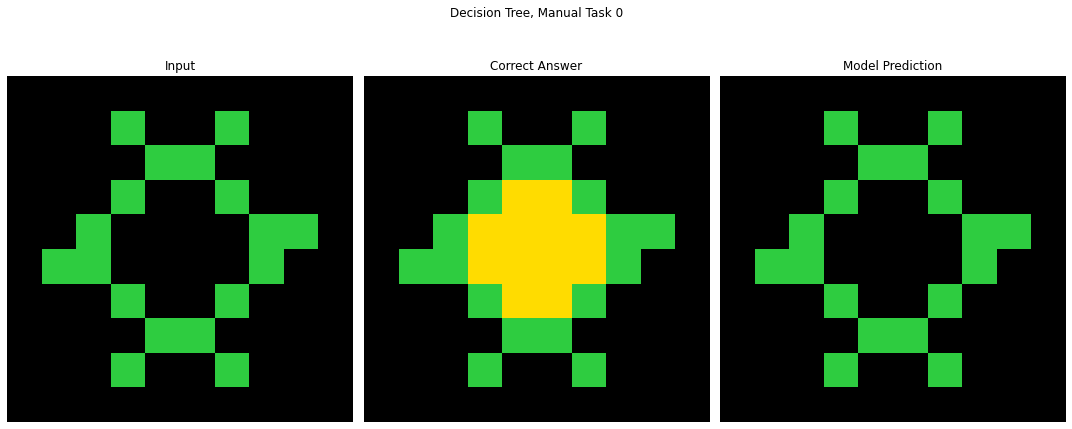

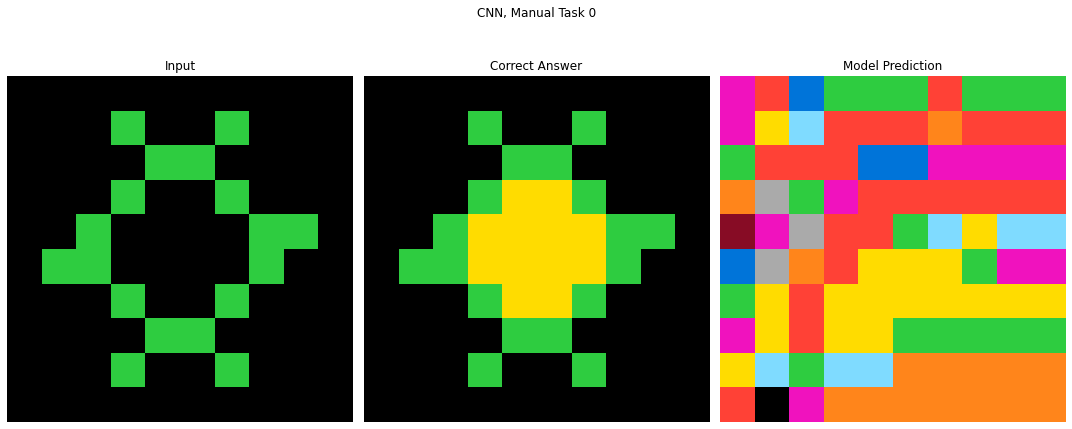

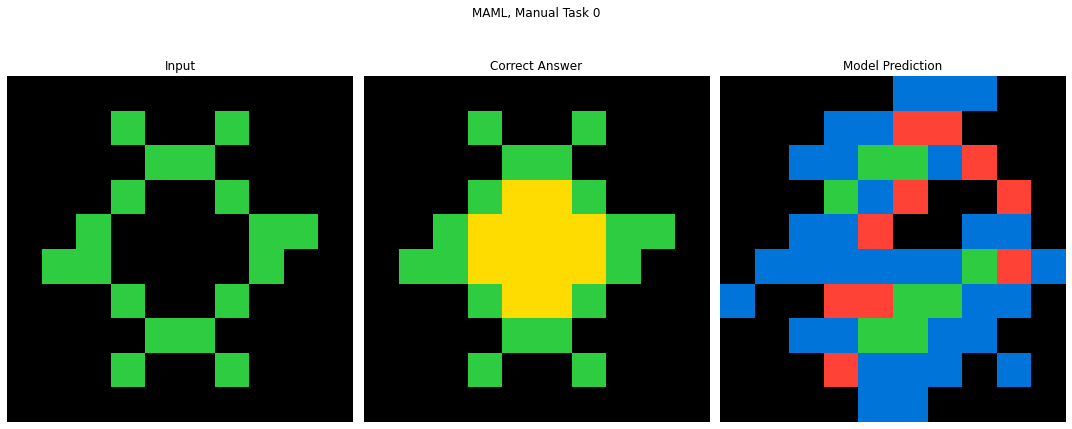

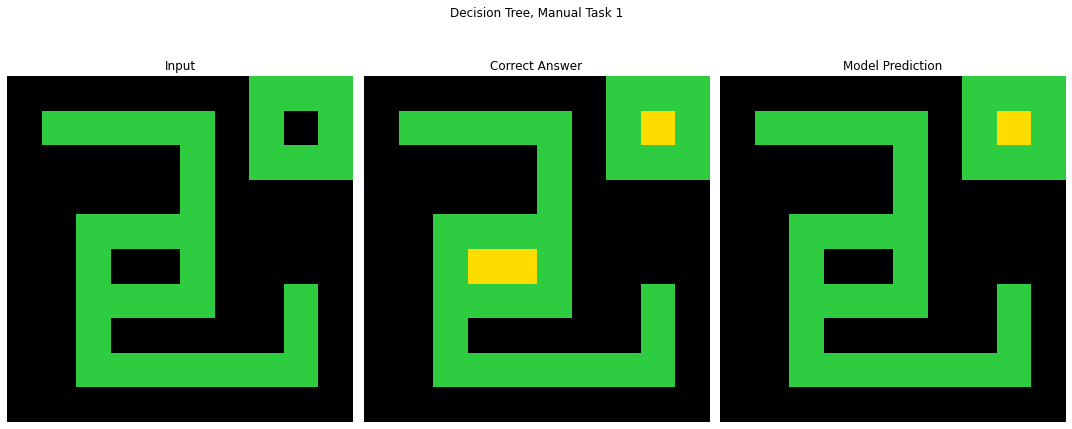

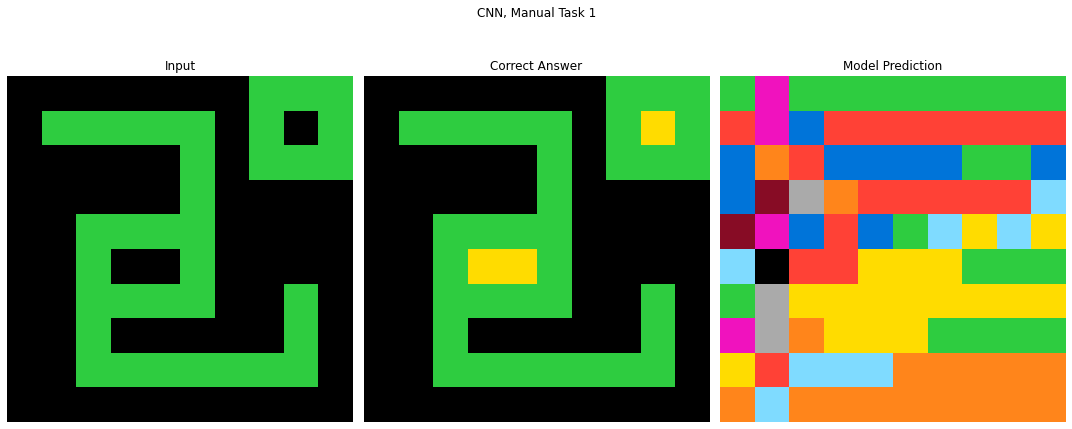

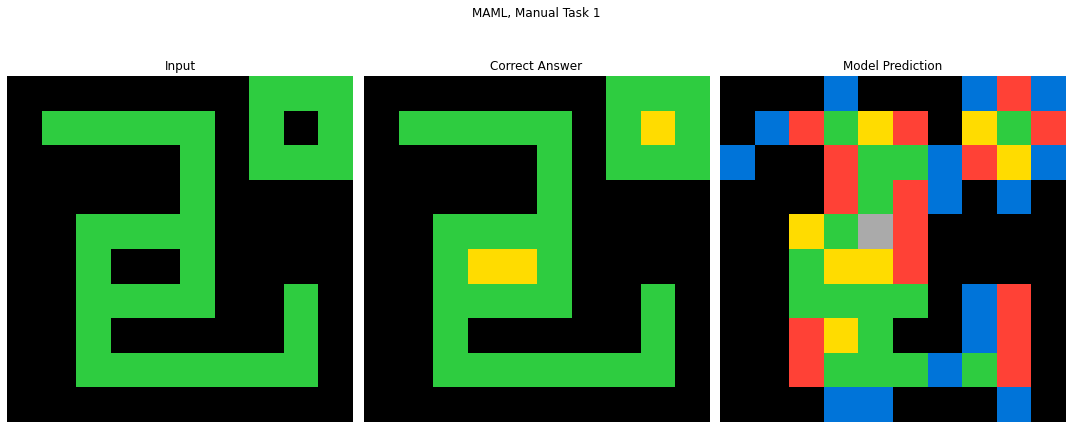

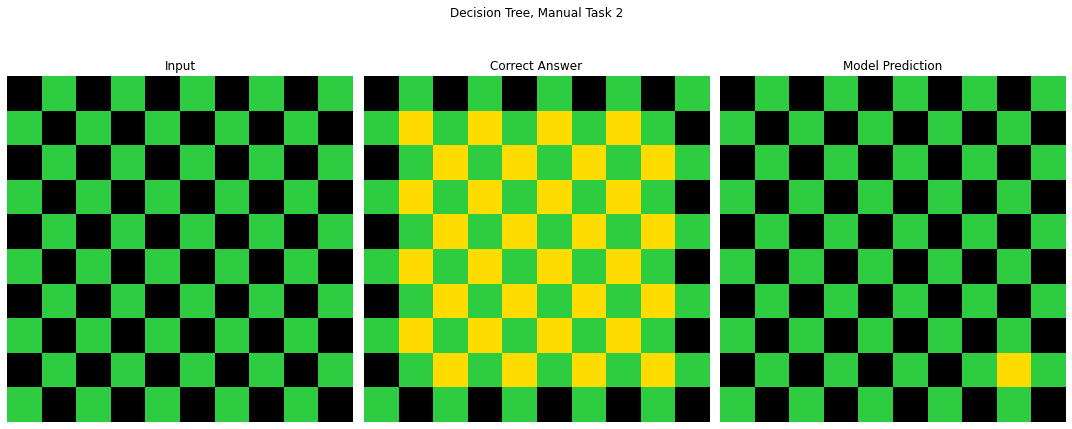

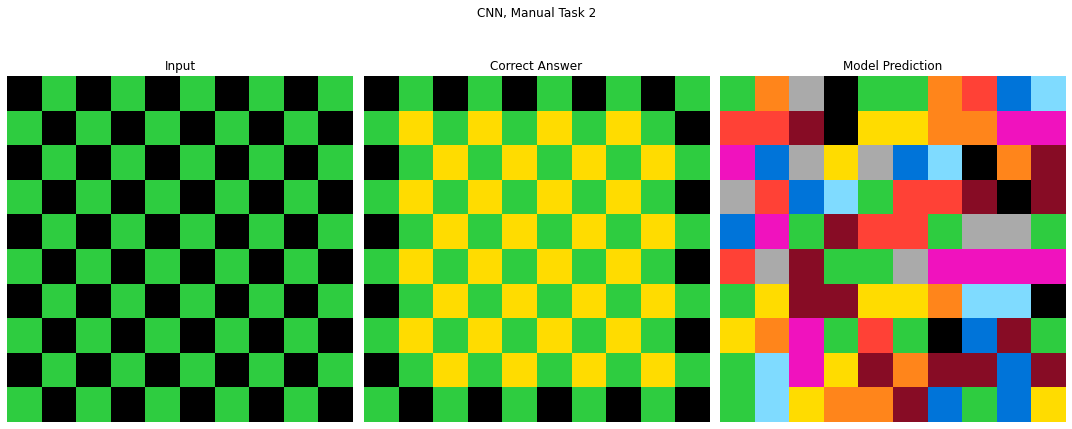

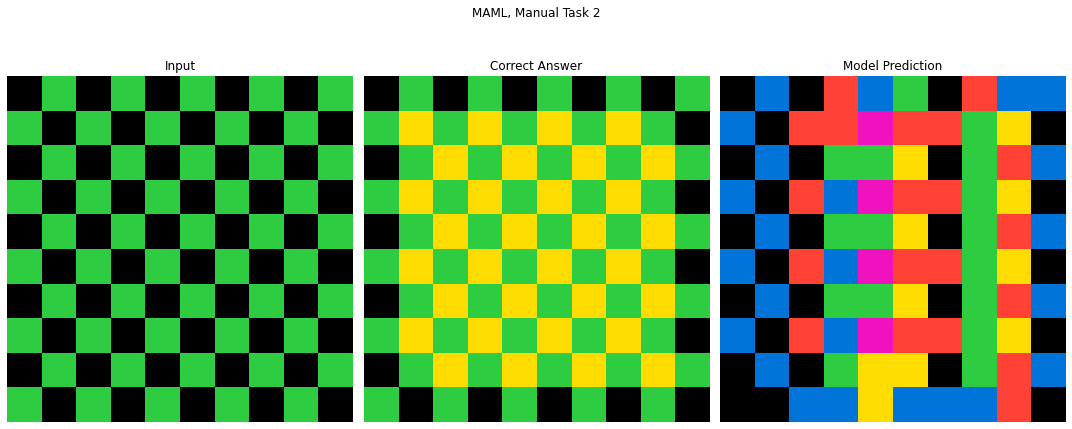

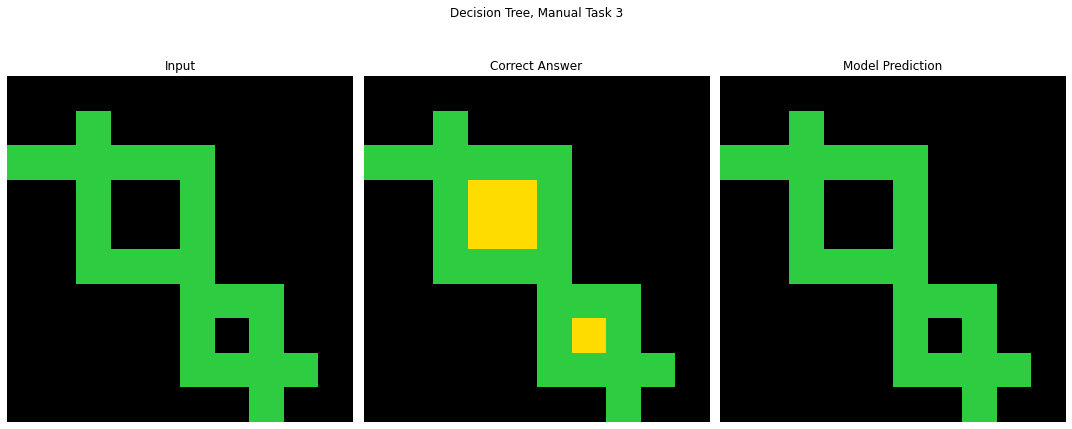

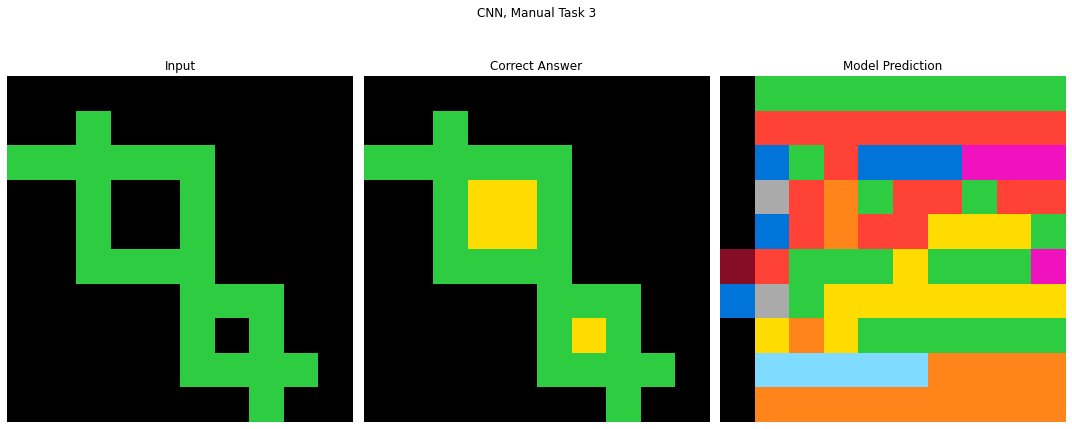

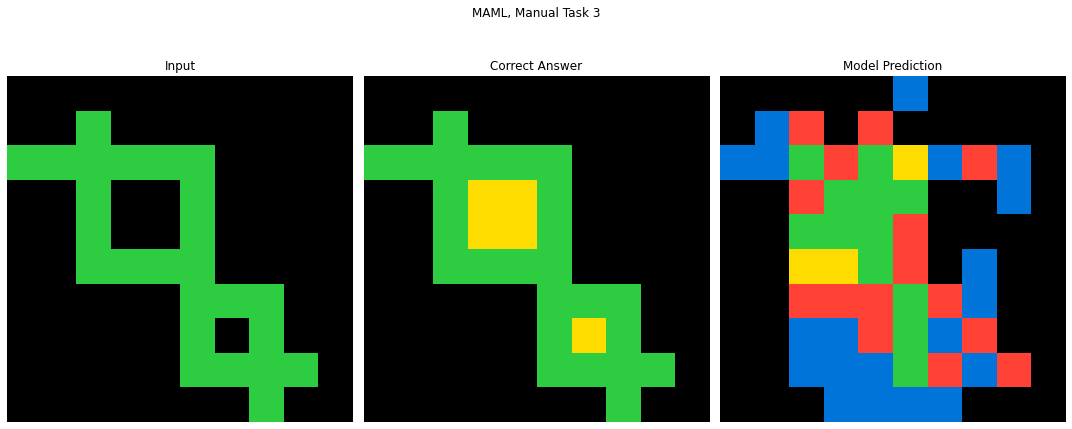

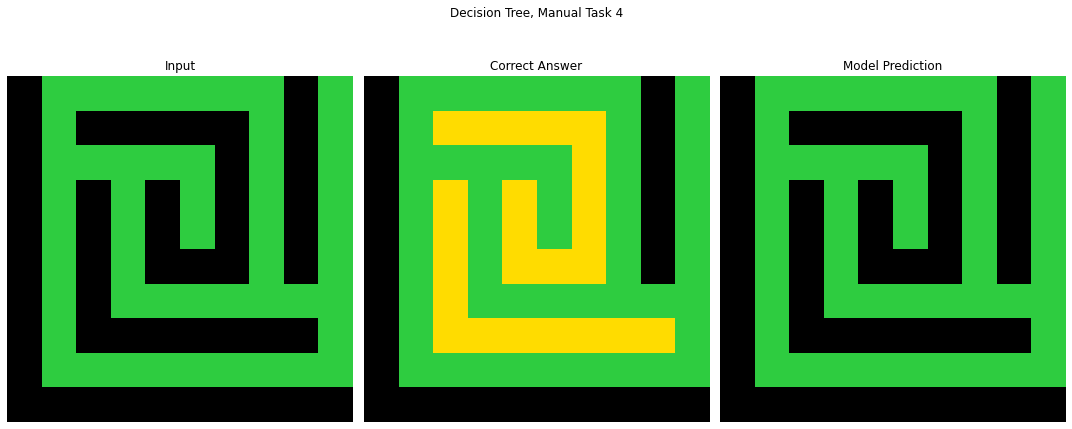

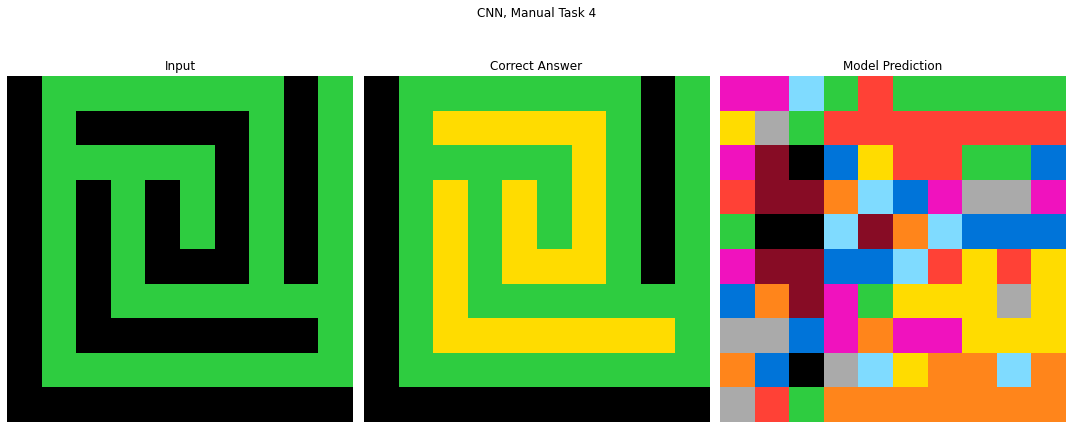

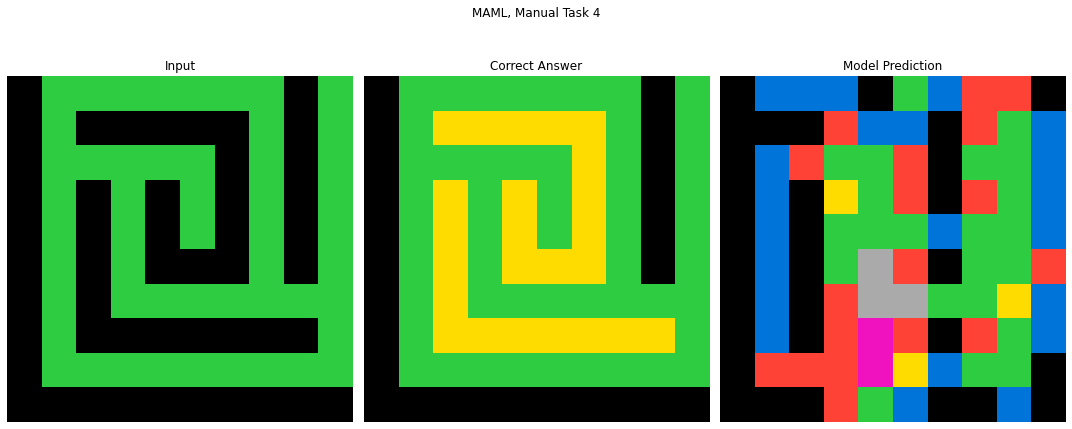

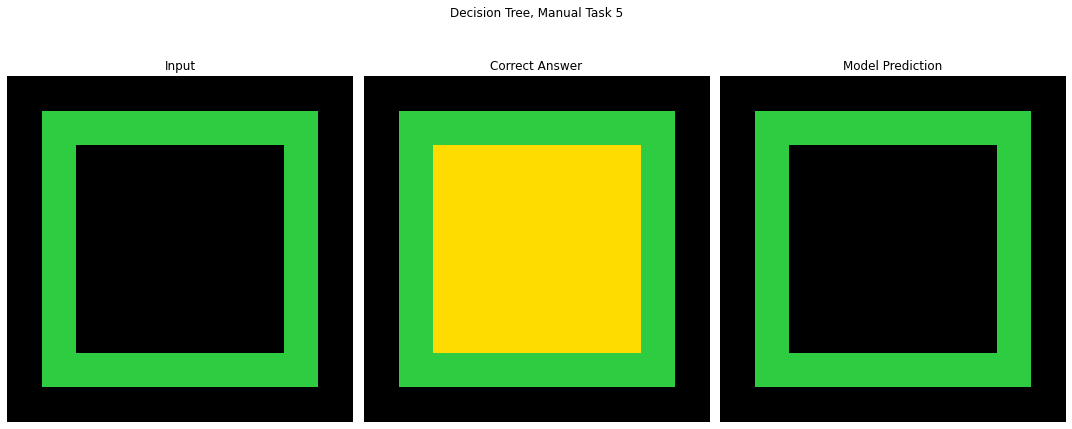

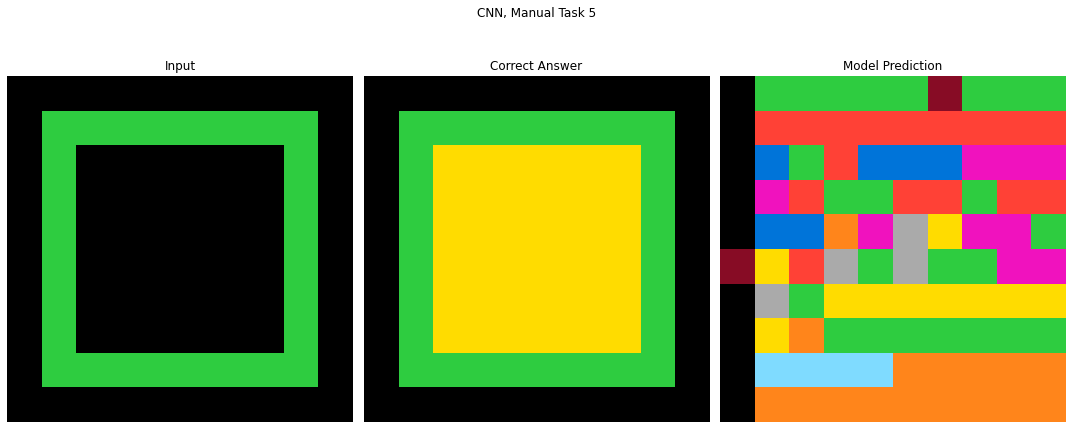

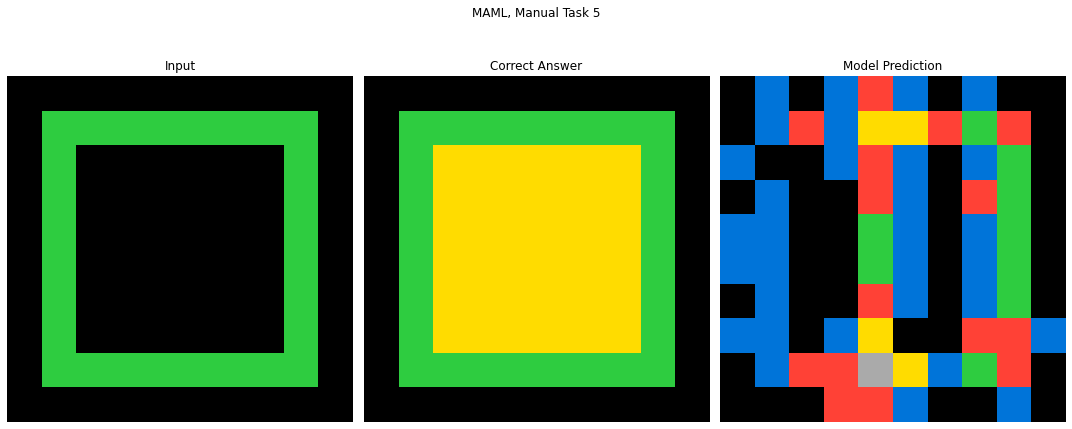

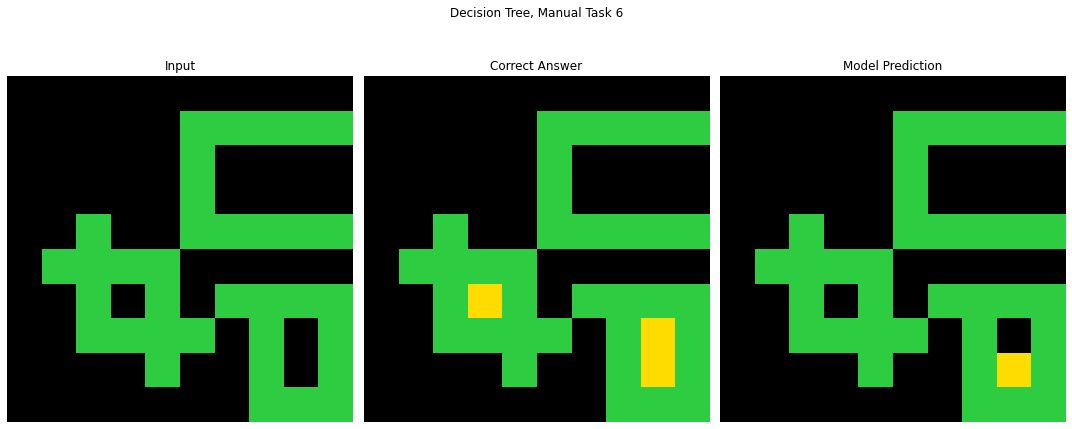

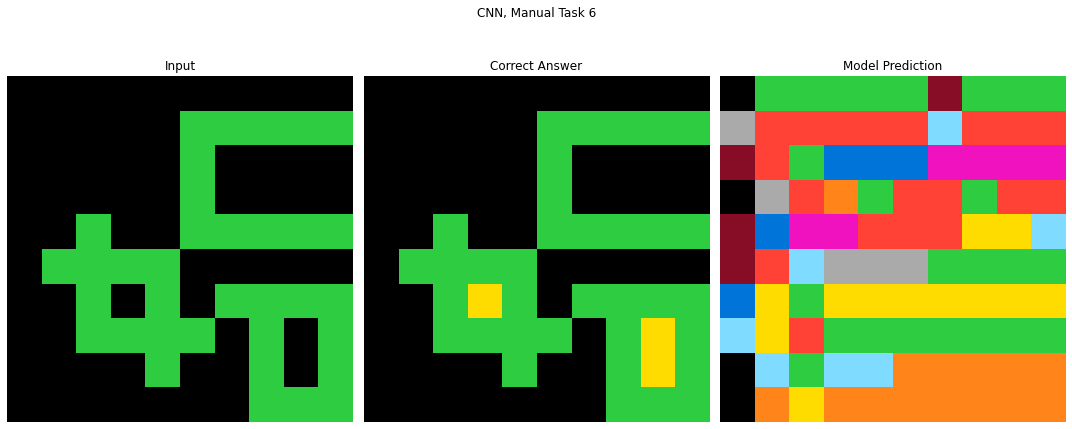

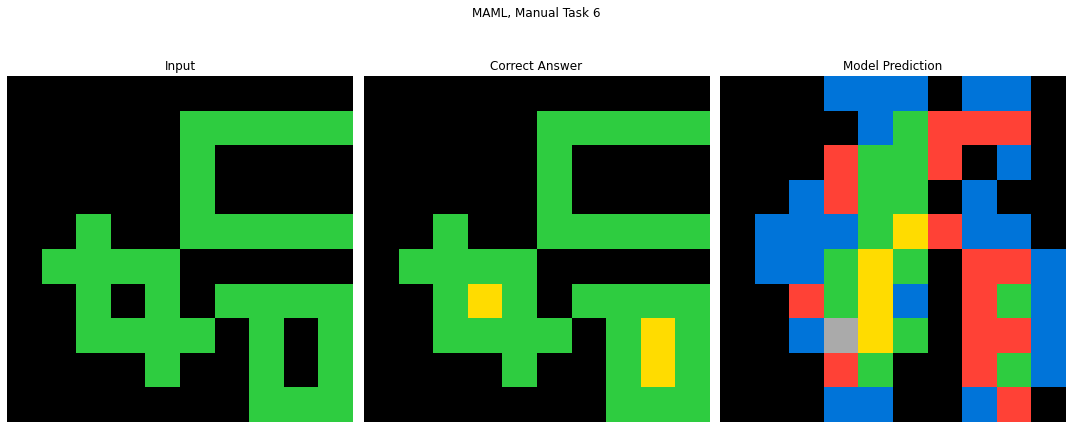

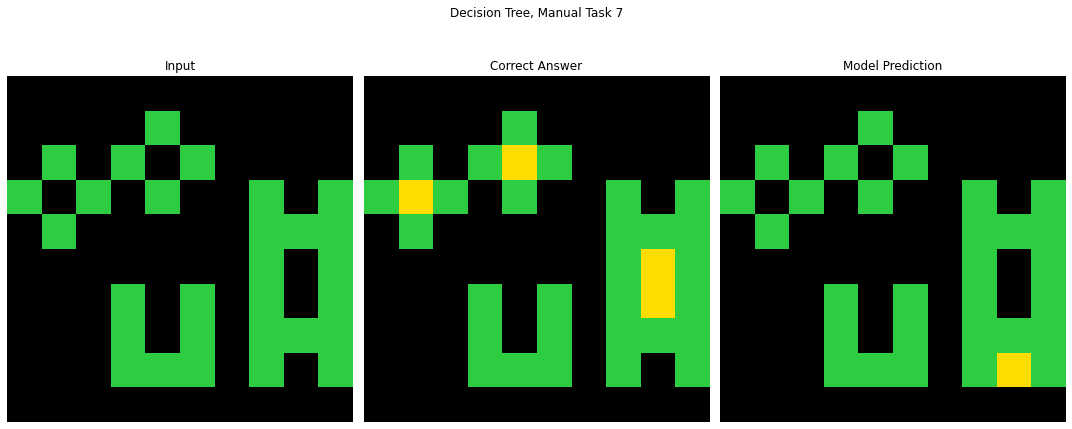

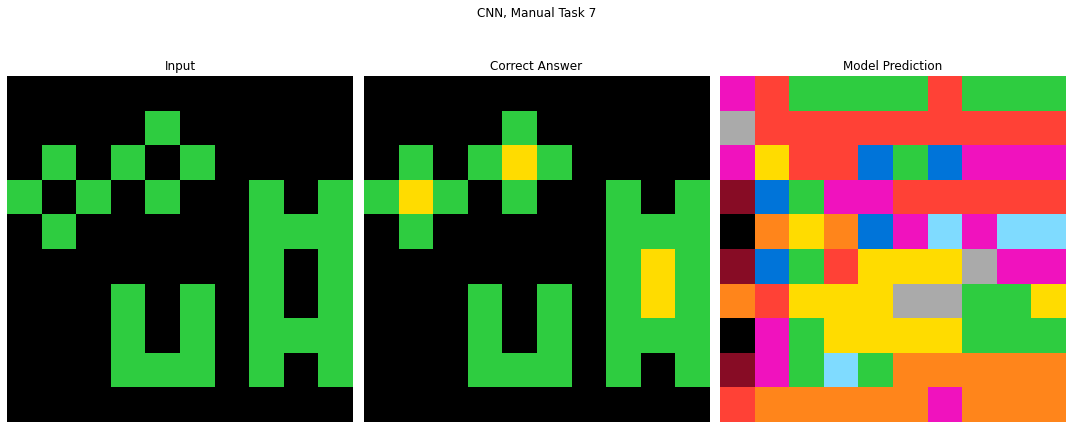

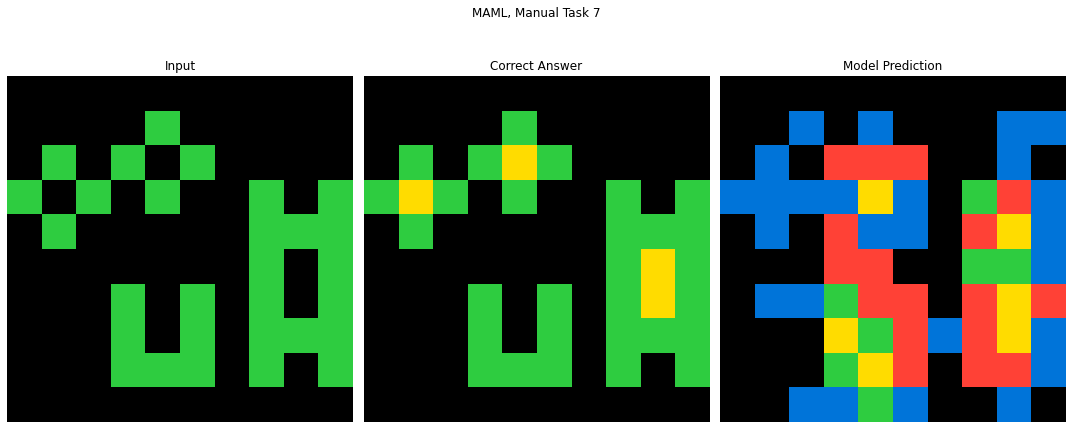

{'DT': [0.88, 0.98, 0.69, 0.95, 0.76, 0.64, 0.98, 0.95], 'CNN': [0.08, 0.09, 0.07, 0.13, 0.09, 0.16, 0.11, 0.09], 'MAML': [0.51, 0.57, 0.23, 0.54, 0.27, 0.3, 0.43, 0.44]}


In [ ]:
#run all manual test pairs
accuracies_manual = dict({'DT':[], 'CNN':[], 'MAML':[]})

eval_results_dir = os.path.join(eval_task_path, 'manual_tasks', 'results')
picpath = os.path.join(eval_results_dir, 'pics')

if not os.path.exists(picpath):
  os.makedirs(picpath)

#loop through all tasks and feed to each model
for m in range(0,8):
  test = eval_manual_tasks['input'][m]
  corres = eval_manual_tasks['output'][m]

  #Decision tree
  feat = make_features(test, 13) #13 features
  y_pred_decision_tree = xgb.predict(feat).reshape(10,10)
  accuracies_manual['DT'].append(np.count_nonzero(y_pred_decision_tree == corres)/100)
  savepath = os.path.join(picpath, 'result_%i_decision_tree.png' % m)
  plot_result_all(test, corres, y_pred_decision_tree, (10,10), savepath, 'Decision Tree, Manual Task %i' % m)

  #CNN
  y_pred_cnn = npy(network.forward(T(test).unsqueeze(0).cuda(), out_d.cuda()))
  y_pred_cnn = np.argmax(y_pred_cnn.reshape((10, *outp_dim)), axis=0)
  accuracies_manual['CNN'].append(np.count_nonzero(np.around(y_pred_cnn) == corres)/100)
  savepath = os.path.join(picpath, 'result_%i_cnn.png' % m)
  plot_result_all(test, corres, y_pred_cnn, (10,10), savepath, 'CNN, Manual Task %i' % m)


  #MAML
  x_test = np.expand_dims(test,axis=0)
  x_test = np.expand_dims(x_test,axis=0)
  y_pred_maml = model.forward(x_test)
  y_pred_maml = np.around(np.array(tf.constant(y_pred_maml[0][0])))
  accuracies_manual['MAML'].append(np.count_nonzero(y_pred_maml == corres)/100)
  savepath = os.path.join(picpath, 'result_%i_maml.png' % m)
  plot_result_all(test, corres, y_pred_maml, (10,10), savepath, 'MAML, Manual Task %i' % m)


np.save(os.path.join(eval_results_dir, 'model_accuracies.npy'), accuracies_manual)
print(accuracies_manual)


###Random tasks

In [ ]:
#load random tests pairs

eval_random_tasks = dict([('input',[]), ('output',[])])
for i in range(1, 9):
  eval_file_x = genfromtxt(os.path.join(eval_task_path, "random_task_%i_x.csv" % i), delimiter=',')
  eval_random_tasks['input'].append(eval_file_x)
  eval_file_y = genfromtxt(os.path.join(eval_task_path, "random_task_%i_y.csv" % i), delimiter=',')
  eval_random_tasks['output'].append(eval_file_y)

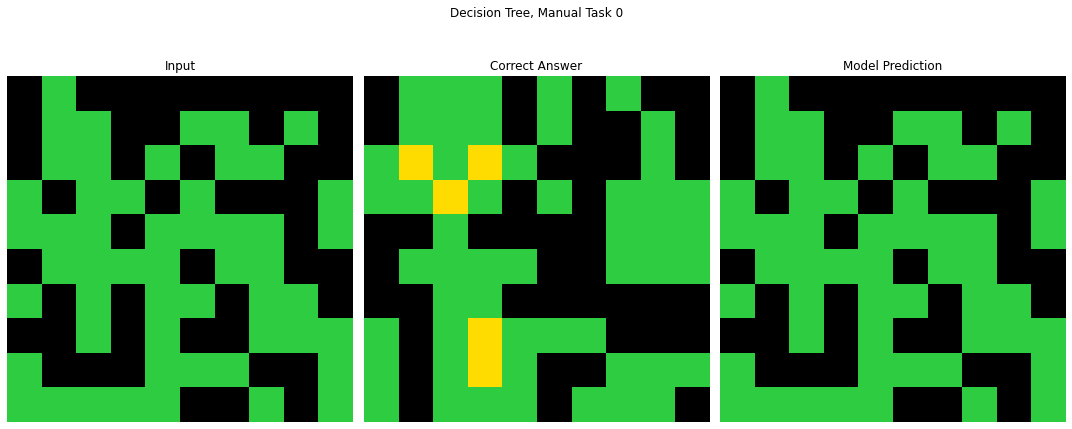

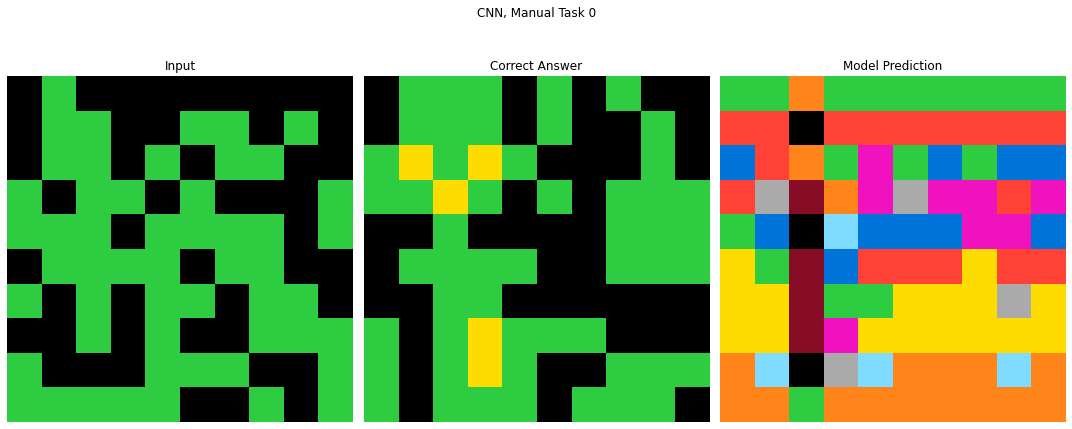

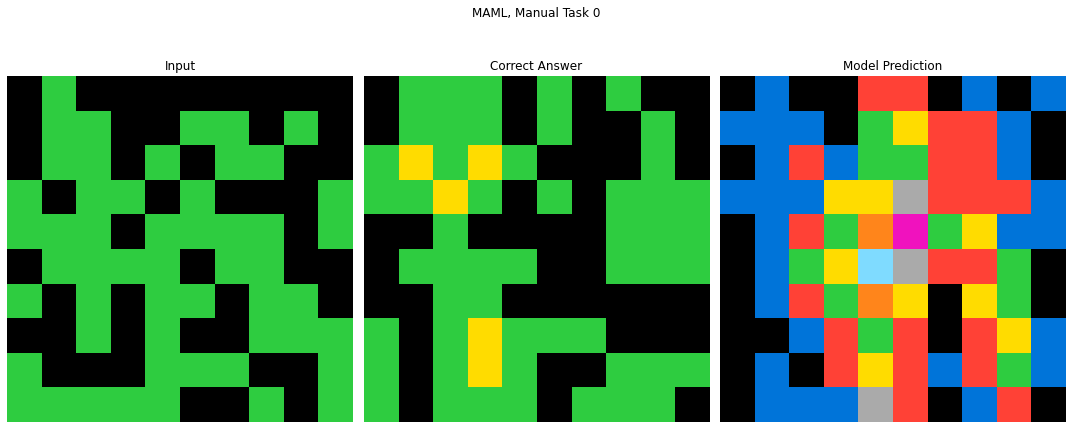

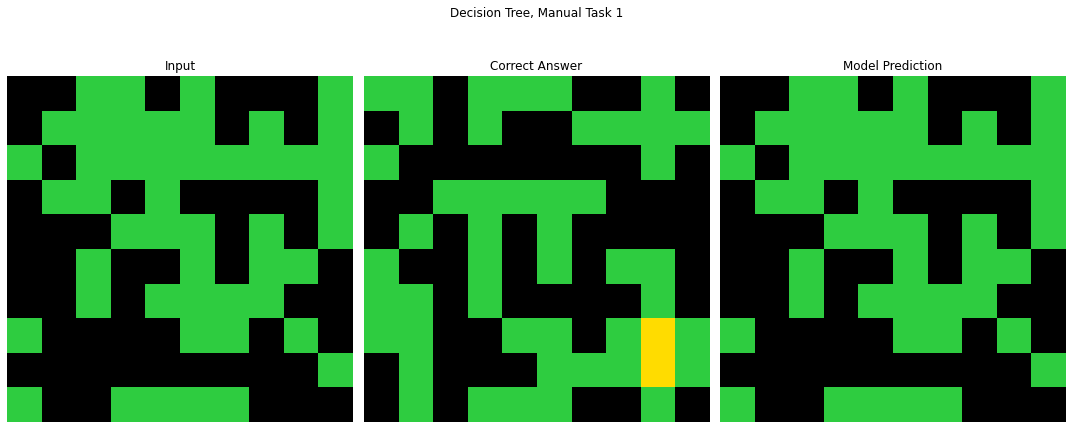

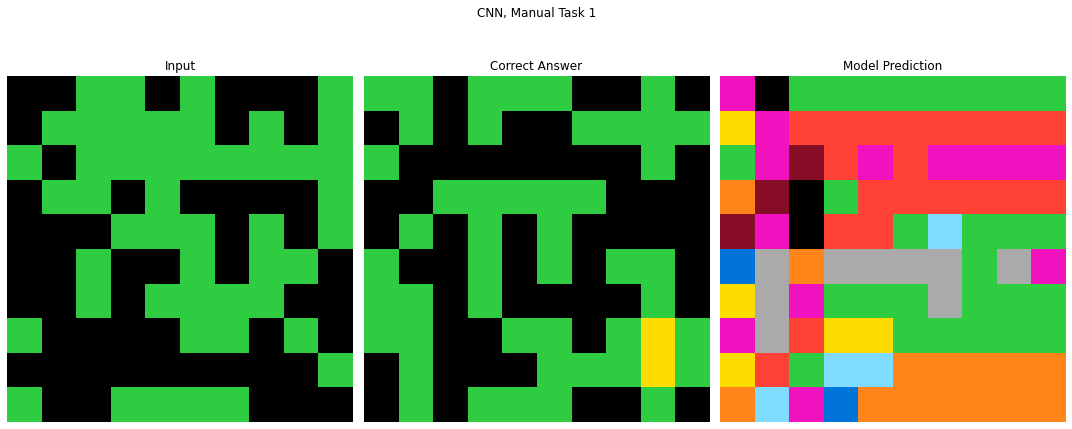

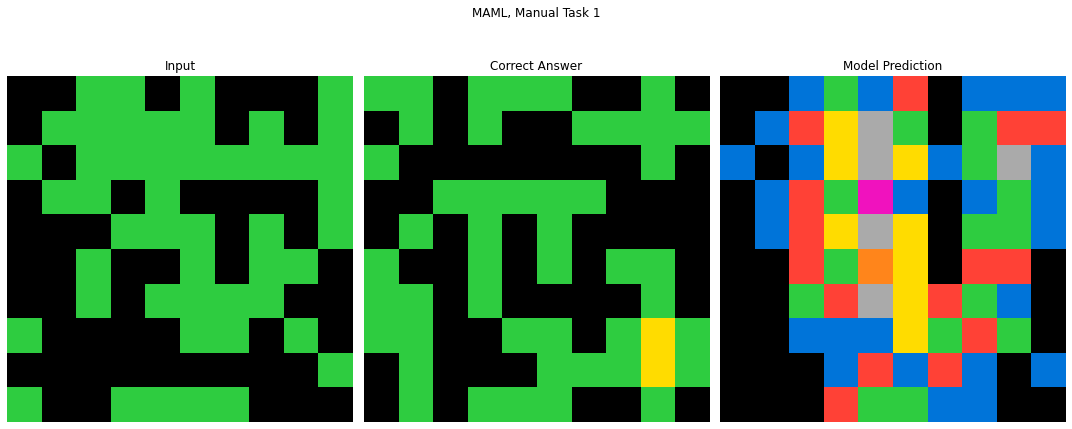

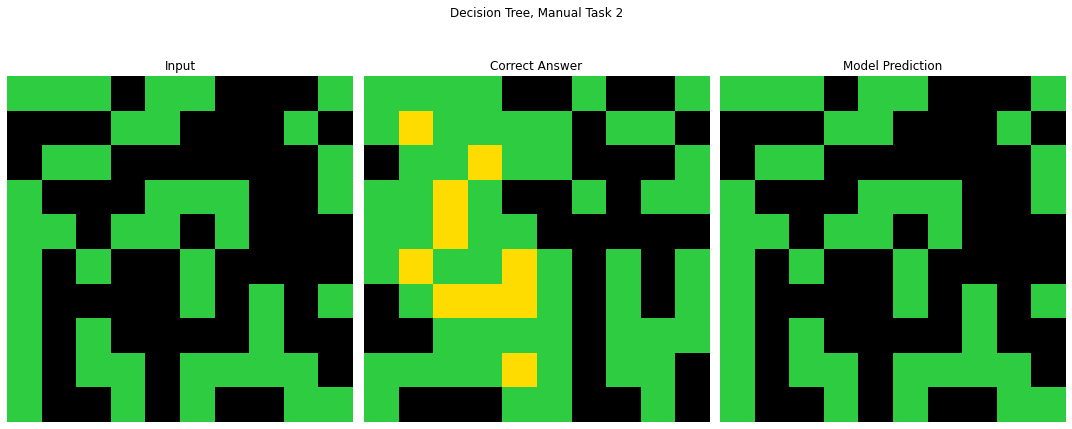

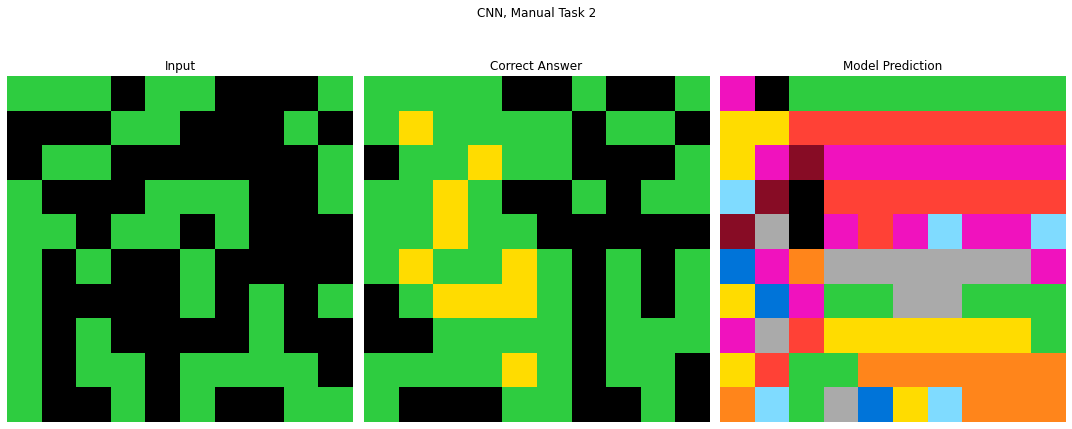

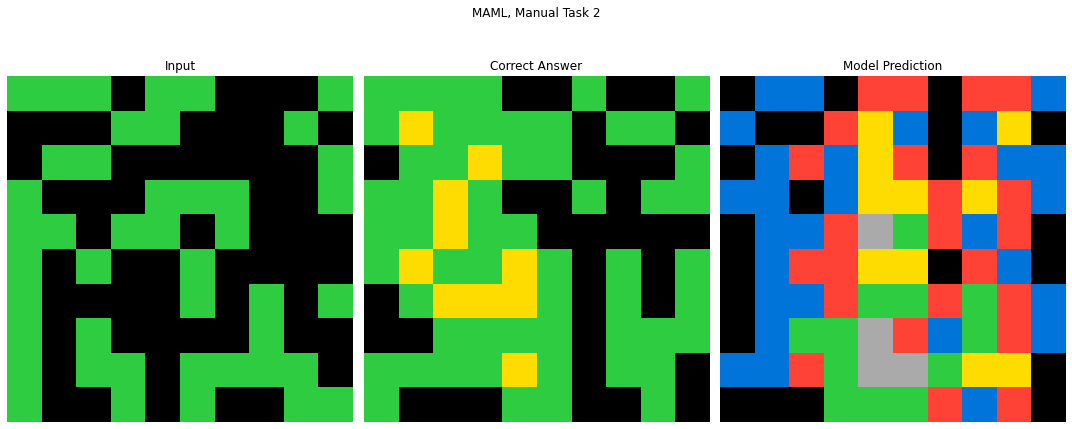

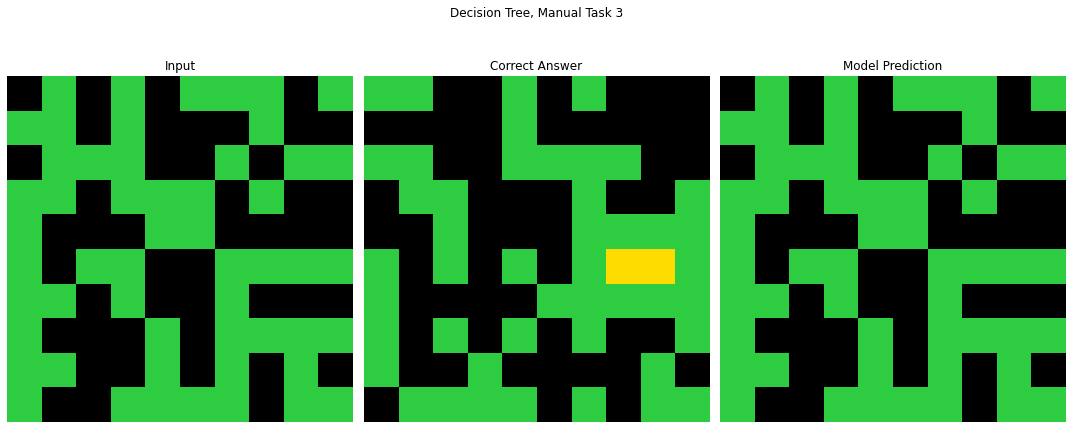

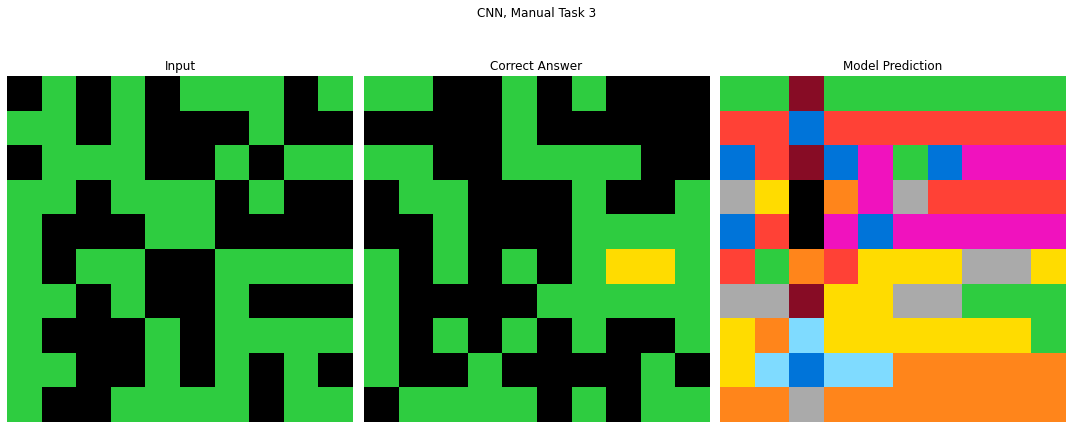

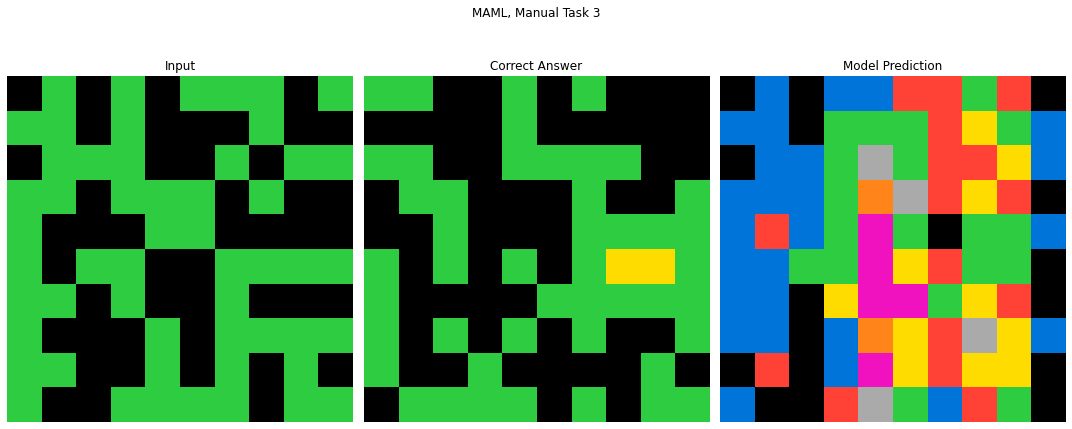

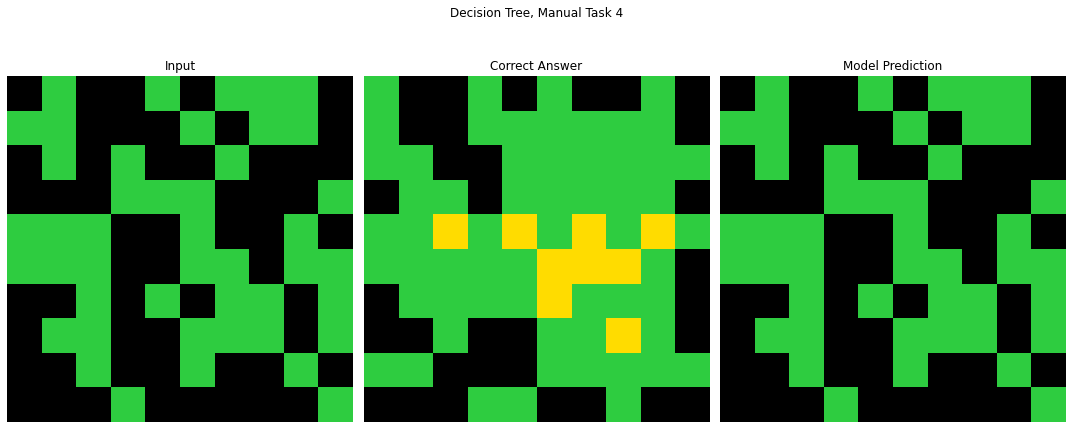

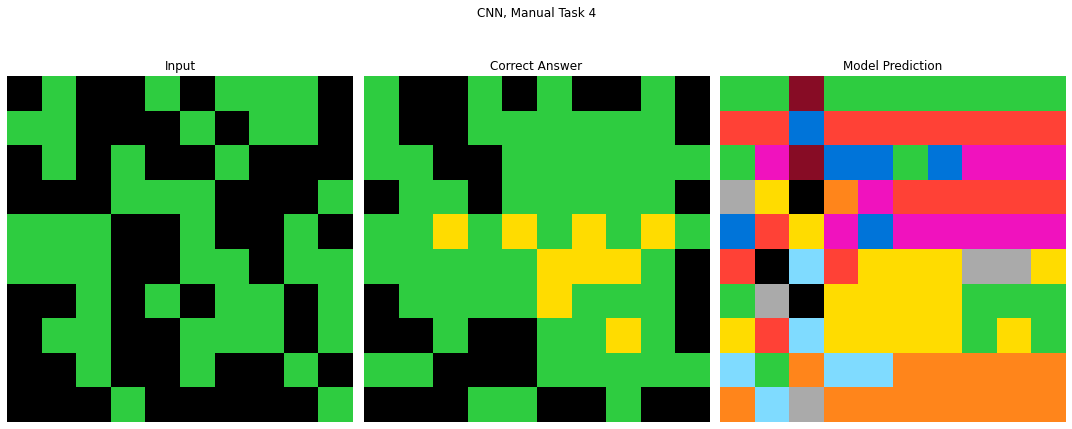

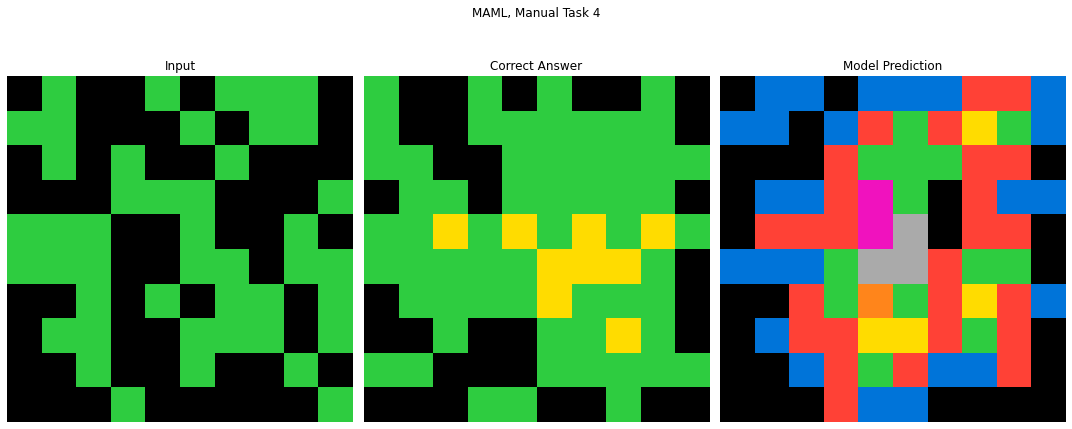

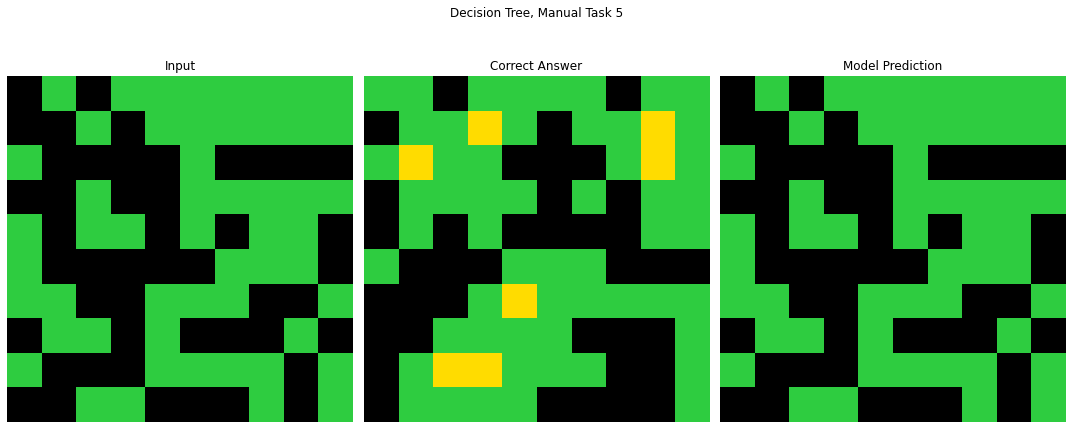

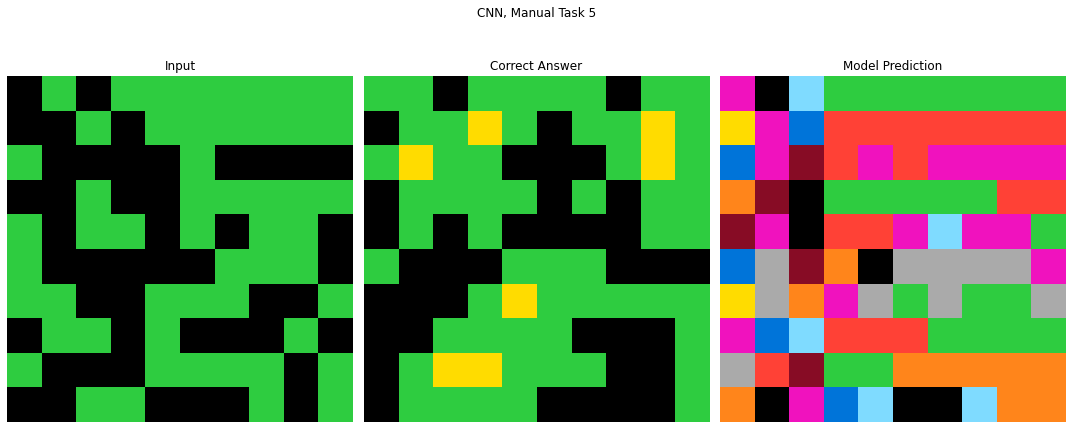

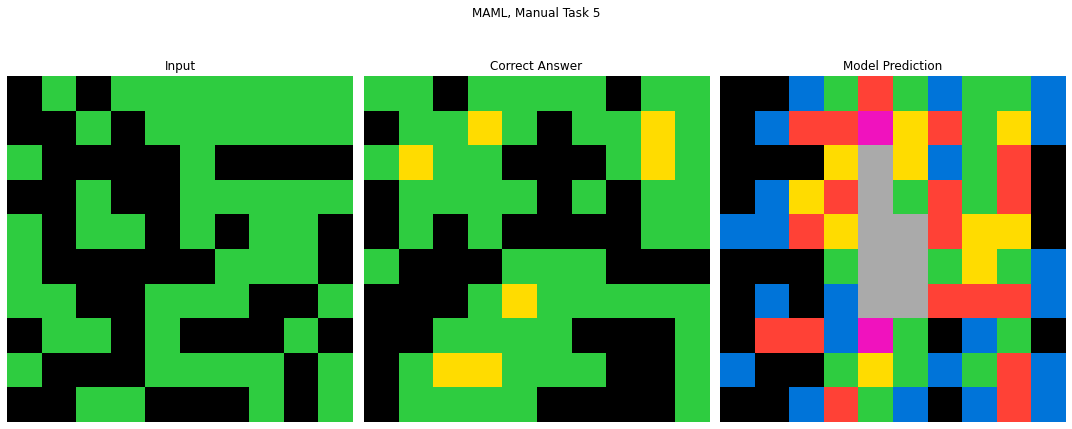

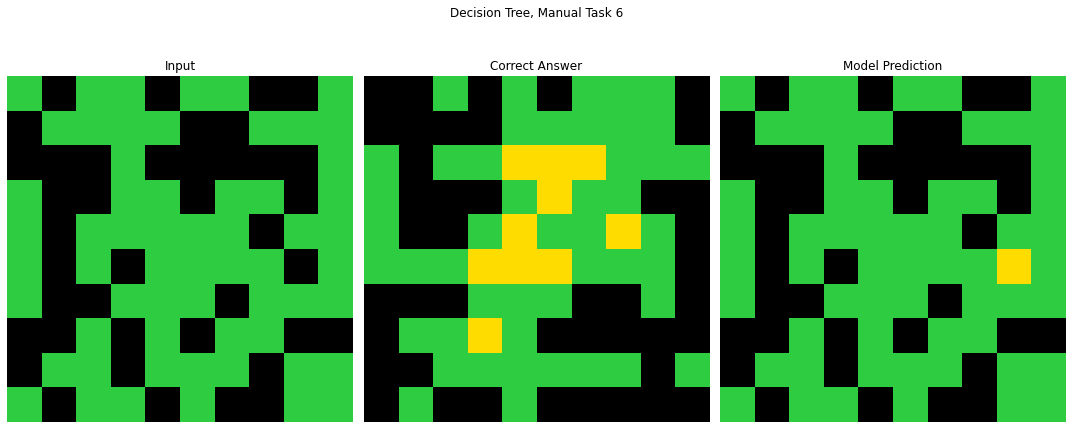

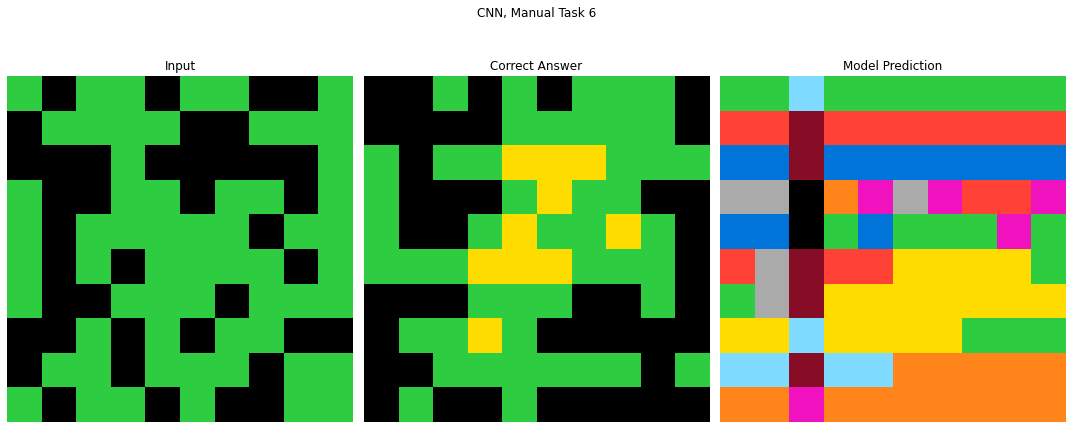

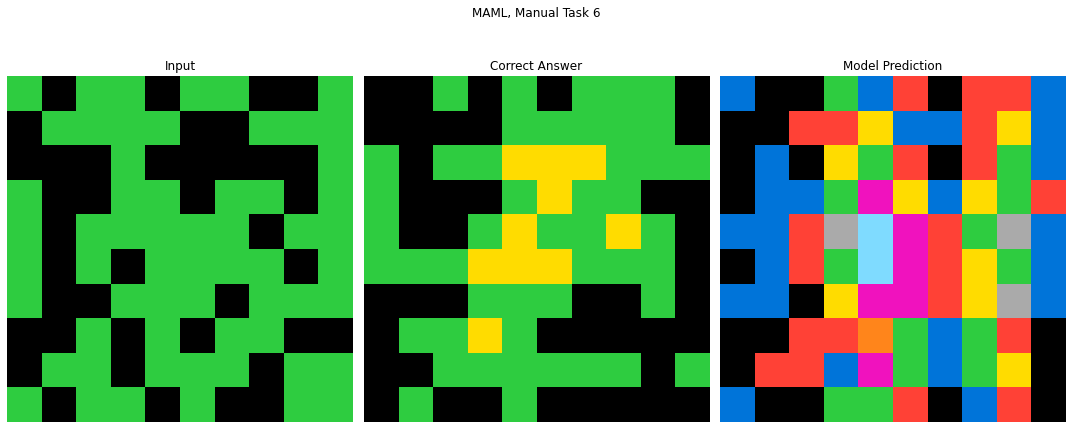

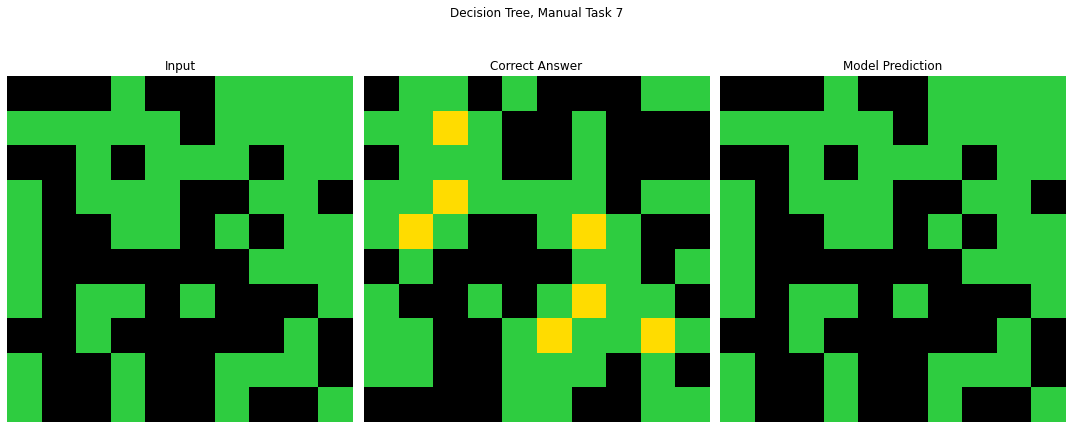

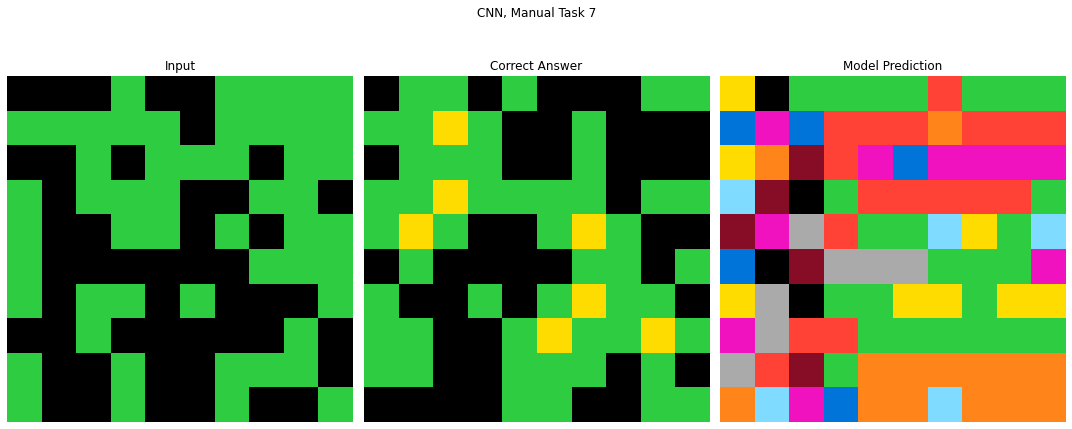

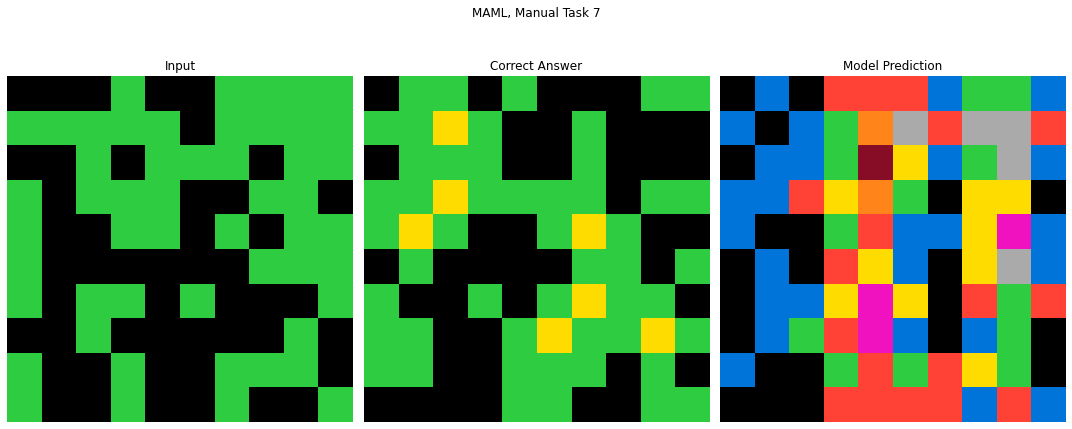

{'DT': [0.52, 0.46, 0.58, 0.44, 0.44, 0.53, 0.48, 0.39], 'CNN': [0.07, 0.14, 0.1, 0.09, 0.13, 0.18, 0.11, 0.17], 'MAML': [0.18, 0.19, 0.2, 0.1, 0.2, 0.19, 0.15, 0.14]}


In [ ]:
#run all random test pairs
accuracies_random = dict({'DT':[], 'CNN':[], 'MAML':[]})

eval_results_dir = os.path.join(eval_task_path, 'random_tasks', 'results')
picpath = os.path.join(eval_results_dir, 'pics')

if not os.path.exists(picpath):
  os.makedirs(picpath)

#loop through all tasks and feed to each model
for m in range(0,8):
  test = eval_random_tasks['input'][m]
  corres = eval_random_tasks['output'][m]

  #Decision tree
  feat = make_features(test, 13) #13 features
  y_pred_decision_tree = xgb.predict(feat).reshape(10,10)
  accuracies_random['DT'].append(np.count_nonzero(y_pred_decision_tree == corres)/100)
  savepath = os.path.join(picpath, 'result_%i_decision_tree.png' % m)
  plot_result_all(test, corres, y_pred_decision_tree, (10,10), savepath, 'Decision Tree, Manual Task %i' % m)

  #CNN
  y_pred_cnn = npy(network.forward(T(test).unsqueeze(0).cuda(), out_d.cuda()))
  y_pred_cnn = np.argmax(y_pred_cnn.reshape((10, *outp_dim)), axis=0)
  accuracies_random['CNN'].append(np.count_nonzero(np.around(y_pred_cnn) == corres)/100)
  savepath = os.path.join(picpath, 'result_%i_cnn.png' % m)
  plot_result_all(test, corres, y_pred_cnn, (10,10), savepath, 'CNN, Manual Task %i' % m)


  #MAML
  x_test = np.expand_dims(test,axis=0)
  x_test = np.expand_dims(x_test,axis=0)
  y_pred_maml = model.forward(x_test)
  y_pred_maml = np.around(np.array(tf.constant(y_pred_maml[0][0])))
  accuracies_random['MAML'].append(np.count_nonzero(y_pred_maml == corres)/100)
  savepath = os.path.join(picpath, 'result_%i_maml.png' % m)
  plot_result_all(test, corres, y_pred_maml, (10,10), savepath, 'MAML, Manual Task %i' % m)


np.save(os.path.join(eval_results_dir, 'model_accuracies.npy'), accuracies_random)
print(accuracies_random)

##Comparison

In [ ]:
#descriptives
means = {'Manual':{'DT': 0, 'CNN':0, 'MAML':0}, 'Random':{'DT': 0, 'CNN': 0, 'MAML':0}}
means['Manual']['MAML'] = np.mean(accuracies_manual['MAML'])
means['Manual']['CNN'] = np.mean(accuracies_manual['CNN'])
means['Manual']['DT'] = np.mean(accuracies_manual['DT'])

means['Random']['MAML'] = np.mean(accuracies_random['MAML'])
means['Random']['CNN'] = np.mean(accuracies_random['CNN'])
means['Random']['DT'] = np.mean(accuracies_random['DT'])

#print means
print('Manual tasks accuracy means:')
print(means['Manual'])
print('Random tasks accuracy means: ')
print(means['Random'])

Manual tasks accuracy means:
{'DT': 0.85375, 'CNN': 0.10250000000000001, 'MAML': 0.41125}
Random tasks accuracy means: 
{'DT': 0.48, 'CNN': 0.12375000000000001, 'MAML': 0.16875}


In [ ]:
#run t-tests to compare MAML performance to CNN and Decision trees

ttest = {'Manual':{'MAML_vs_CNN':[], 'MAML_vs_DT':[]}, 'Random':{'MAML_vs_CNN':[], 'MAML_vs_DT':[]}}

#manual tasks
ttest['Manual']['MAML_vs_CNN'] = ttest_rel(accuracies_manual['MAML'], accuracies_manual['CNN'])
ttest['Manual']['MAML_vs_DT'] = ttest_rel(accuracies_manual['MAML'], accuracies_manual['DT'])

#random tasks
ttest['Random']['MAML_vs_CNN'] = ttest_rel(accuracies_random['MAML'], accuracies_random['CNN'])
ttest['Random']['MAML_vs_DT'] = ttest_rel(accuracies_random['MAML'], accuracies_random['DT'])

#print results
print('Manual: MAML vs CNN:')
print(ttest['Manual']['MAML_vs_CNN'])

print('Manual: MAML vs DT:')
print(ttest['Manual']['MAML_vs_DT'])

print('Random: MAML vs CNN:')
print(ttest['Random']['MAML_vs_CNN'])

print('Random: MAML vs DT:')
print(ttest['Random']['MAML_vs_DT'])

Manual: MAML vs CNN:
Ttest_relResult(statistic=6.580235800771461, pvalue=0.0003099563085656277)
Manual: MAML vs DT:
Ttest_relResult(statistic=-17.320626546611074, pvalue=5.256041488103176e-07)
Random: MAML vs CNN:
Ttest_relResult(statistic=2.662235902394827, pvalue=0.03236200077234713)
Random: MAML vs DT:
Ttest_relResult(statistic=-17.318652635083332, pvalue=5.260151259657549e-07)
